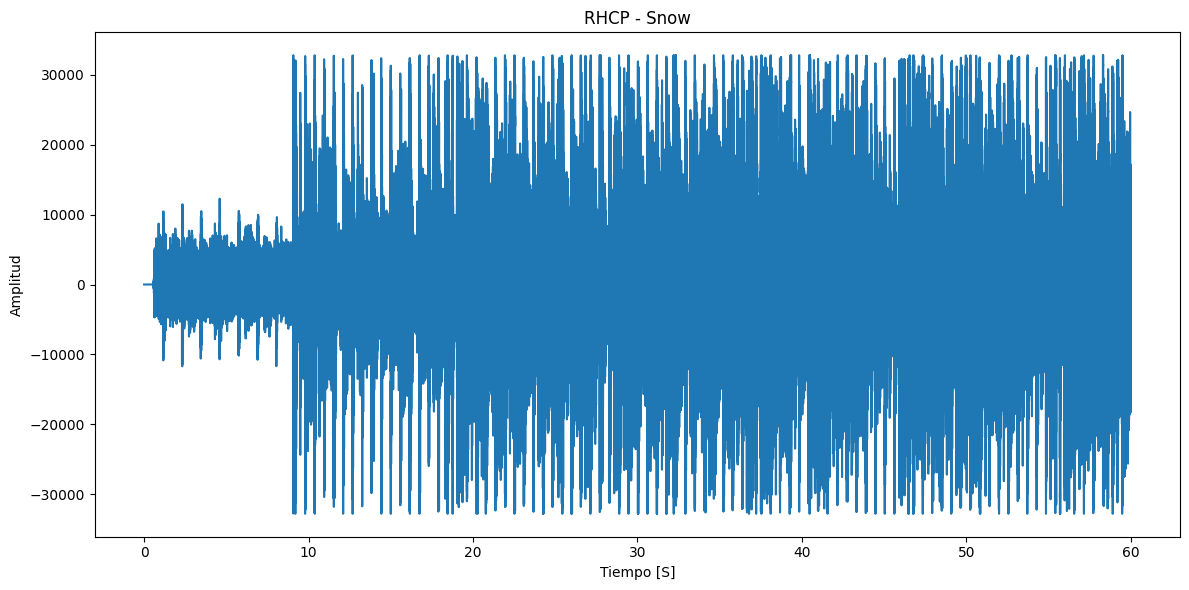

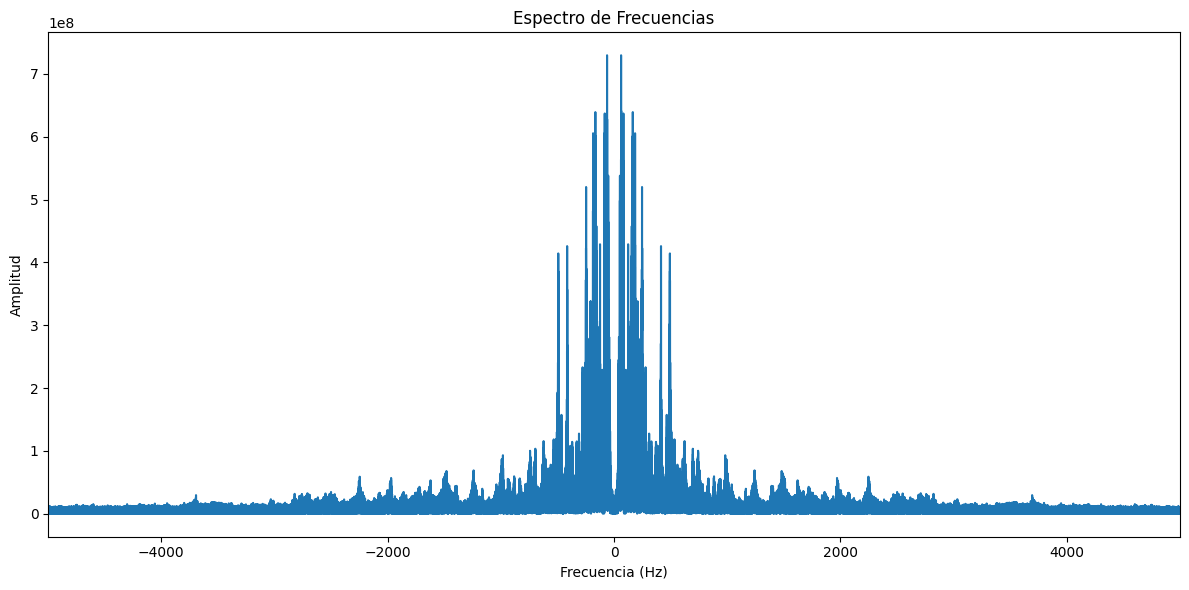

Audio RHCP - Snow (Primer minuto)


In [9]:
from IPython.display import Audio
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import numpy as np

fs1, data1 = read('Red Hot Chili Peppers - Snow.wav')

# Convertir el audio estéreo a mono
if len(data1.shape) > 1:
    data1 = np.mean(data1, axis=1)

# Recortar a un minuto
data1 = data1[:fs1*60]

time1 = np.arange(0, float(len(data1))/fs1, 1.0/fs1)

plt.figure(figsize=(12, 6))
plt.plot(time1, data1)
plt.title("RHCP - Snow")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo [S]")

plt.tight_layout()
plt.show()

# Calcular la DFT
dft_data1 = np.fft.fft(data1)

# Calcular las frecuencias para el eje x
freqs = np.fft.fftfreq(len(data1), 1/fs1)

# Reordenar las frecuencias y la DFT
freqs_shifted = np.fft.fftshift(freqs)
dft_data1_shifted = np.fft.fftshift(dft_data1)

# Graficar el espectro de frecuencias
plt.figure(figsize=(12, 6))
plt.plot(freqs_shifted, np.abs(dft_data1_shifted))
plt.title("Espectro de Frecuencias")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim(-5000, 5000)
plt.tight_layout()
plt.show()


print("Audio RHCP - Snow (Primer minuto)")
Audio(data1, rate=fs1) # para escuchar la señal, si se desea

Como puede verse, el audio, tiene mayor magnitud en las bajas frecuencias, por lo que si el proceso de filtrado se hace al rededor de estos puntos, se veran cambios significativos. 

In [10]:
# Calcular la magnitud del espectro
magnitude = np.abs(dft_data1)

# Encontrar el índice de la magnitud máxima
max_index = np.argmax(magnitude)

# Encontrar la frecuencia correspondiente
max_freq = freqs[max_index]

print("La frecuencia de mayor magnitud es:", max_freq, "Hz")

La frecuencia de mayor magnitud es: 61.949999999999996 Hz


In [11]:
# Duración del sonido
duration = 10.0  # 10 segundos

# Generar una señal sinusoidal con la frecuencia de mayor magnitud
t = np.linspace(0, duration, int(fs1 * duration), False)
sound = np.sin(max_freq * t * 2 * np.pi)

# Normalizar a 16-bit range
sound *= 32767 / np.max(np.abs(sound))
sound = sound.astype(np.int16)

# Reproducir el sonido
Audio(sound, rate=fs1)

<h2>Parte 2: Diseño y aplicación de filtros FIR<h2>

In [22]:
def ventana(name='Hamming', M=20):
    # Rect/Hanning/Hamming
    if name == 'Hamming':
        window = np.array([0.54 - 0.46 * np.cos(2 * np.pi * n / (M - 1)) for n in range(M)])
    elif name == 'Hanning':
        window = np.array([0.5 - 0.5 * np.cos(2 * np.pi * n / (M - 1)) for n in range(M)])
    elif name == 'Rect':
        window = np.ones(M)
    elif name == 'black':
        window = np.array([0.42-0.5*np.cos((2*np.pi*n)/(M-1))+0.08*np.cos((4*np.pi*n)/(M-1))for n in range(M)])
    return window

In [21]:
def orden_filtro(bw , fs,  name = "Hamming"): # RECIBE EL ANCHO DE BANDA QUE SE QUIERE Y LA VENTANA
    
    bwn=2*np.pi*BW/fs # ancho de banda  normalizado en radianes
    
    if name == 'Hamming':
        M = int((8*np.pi)/bwn) # orden estimado del filtro, ventana Hamming
    elif name == 'Hanning':
        M = int((8*np.pi)/bwn) # orden estimado del filtro , ventana Hanning
    elif name == 'Rect': 
        M = int((4*np.pi)/bwn)-1
    elif name == 'black':
         M = int((12*np.pi)/bwn) # Orden estimado del filtro, ventana blackman
            
    if(M%2==0):  # Validamos si M es par y lo volvemos Impar
        M+=1
    
    return M

In [23]:
def filtro(vector_n, name="pasabajas" , fs = 2000 ,  fc1= 500, fc2= 1000): # n es un vector - array con todos los valores que toma n desde -M hasta M
    
    #Normalizamos y calculamos lo que falta.
    wc1 = (2*np.pi*fc1)/fs
    wc2 = (2*np.pi*fc2)/fs
    fc1 = fc1/fs
    fc2 = fc2/fs
    
    if name == "pasabajas":
        hn  =   np.array([ 2*fc1 * np.sin(wc1*(n))/(wc1*n) if(n!=0) else 2*fc1 for n in vector_n])
    elif  name == "pasaaltas":
        hn  =   np.array([ -(2*fc1 * np.sin(wc1*(n))/(wc1*n)) if(n!=0) else 1-2*fc1 for n in vector_n])
    elif name == "pasabandas":
        hn  =   np.array([ (2*fc2 * np.sin(wc2*(n))/(wc2*n))-(2*fc1 * np.sin(wc1*(n))/(wc1*n))  if(n!=0) else 2*(fc2-fc1) for n in vector_n])
    elif name == "rechazabandas":
        hn  =   np.array([ (2*fc1 * np.sin(wc1*(n))/(wc1*n))-(2*fc2 * np.sin(wc2*(n))/(wc2*n))  if(n!=0) else 1- 2*(fc2-fc1) for n in vector_n])
    
    return hn

<h2>Desarollo</h2>

<p> 1) Se diseñan 4 filtros , pasabaja, pasaalta, pasabanda y rechazabanda, cada uno con una ventana diferente </p>

In [24]:
# DISEÑO DE LOS 4 FILTROS 
fc  = 200    # Primero , se define la frecuencia de corte para el pasabajas y el pasa altas
fs  = 12000  #Segundo , se define la frecuencia de muestreo

# Defino la segunda frecuencia para crear los filtros pasabanda y rechazabanda
fc2 = 800   # Se define asi porque fc < f2 Según la definición de las ecuaciones vistas

BW  = 200    # Ancho de banda en la banda de transicion para todos los filtros

# La funcion orden_filtro me devuelve el valor de M impar
M1 = orden_filtro( BW, fs, "Hamming" ) # Orden para el filtro pasabajas
M2 = orden_filtro( BW, fs, "Hanning" ) # Orden para el filtro pasaaltas
M3 = orden_filtro( BW, fs, "blackman"   ) # Orden para el filtro pasabandas
M4 = orden_filtro( BW, fs, "Rectangular"    ) # Orden para el filtro rechazabandas

#Creo el vector n de cada uno de los filtros
#para luego hallar los valores de la respuesta al impulso de la ventana y la sinc
vector_n_1 = np.arange(-(M1-1)/2,(M1-1)/2 + 1)
vector_n_2 = np.arange(-(M2-1)/2,(M2-1)/2 + 1)
vector_n_3 = np.arange(-(M3-1)/2,(M3-1)/2 + 1)
vector_n_4 = np.arange(-(M4-1)/2,(M4-1)/2 + 1)

# Obtengo la respuesta al impulso de la funcion sinc para cada uno de los filtros
hn_pasabajas     = filtro(vector_n_1, name="pasabajas"     , fs = fs ,  fc1 = fc)
hn_pasaaltas     = filtro(vector_n_2, name="pasaaltas"     , fs = fs ,  fc1 = fc)
hn_pasabandas    = filtro(vector_n_3, name="pasabandas"    , fs = fs ,  fc1 = fc, fc2 = fc2)
hn_rechazabandas = filtro(vector_n_4, name="rechazabandas" , fs = fs ,  fc1 = fc, fc2 = fc2)

# Obtengo la respuesta al impulso de las ventanas que escojo para cada filtro
wn_pasabajas     =  ventana(name='Hamming' , M = M1)
wn_pasaaltas     =  ventana(name='Hanning' , M = M2)
wn_pasabandas    =  ventana(name='blackman'   , M = M3)
wn_rechazabandas =  ventana(name='Rectangular'    , M = M4)

#Multiplicamos para obtener la respuesta del filtro  h'(n) = h(n)*w(n) TRUNCAMIENTO
h_pasabajas      =  hn_pasabajas*wn_pasabajas 
h_pasaaltas      =  hn_pasaaltas*wn_pasaaltas
h_pasabandas     =  hn_pasabandas*wn_pasabandas
h_rechazabandas  =  hn_rechazabandas*wn_rechazabandas

UnboundLocalError: local variable 'M' referenced before assignment

In [16]:
import scipy.signal as signal # para la calcular la transformada

N = 2048 # Numero de puntos de la FFT
# Hallamos la respuesta en frecuencia de cada filtro
w_pasabajas     , Hh_pasabajas     = signal.freqz(h_pasabajas  ,   1, whole=True, worN=N) # Respuesta en frecuencia del filtro enventanado
w_pasaaltas     , Hh_pasaaltas     = signal.freqz(h_pasaaltas ,    1, whole=True, worN=N) # Respuesta en frecuencia del filtro enventanado
w_pasabandas    , Hh_pasabandas    = signal.freqz(h_pasabandas,    1, whole=True, worN=N) # Respuesta en frecuencia del filtro enventanado
w_rechazabandas , Hh_rechazabandas = signal.freqz(h_rechazabandas, 1, whole=True, worN=N) # Respuesta en frecuencia del filtro enventanado

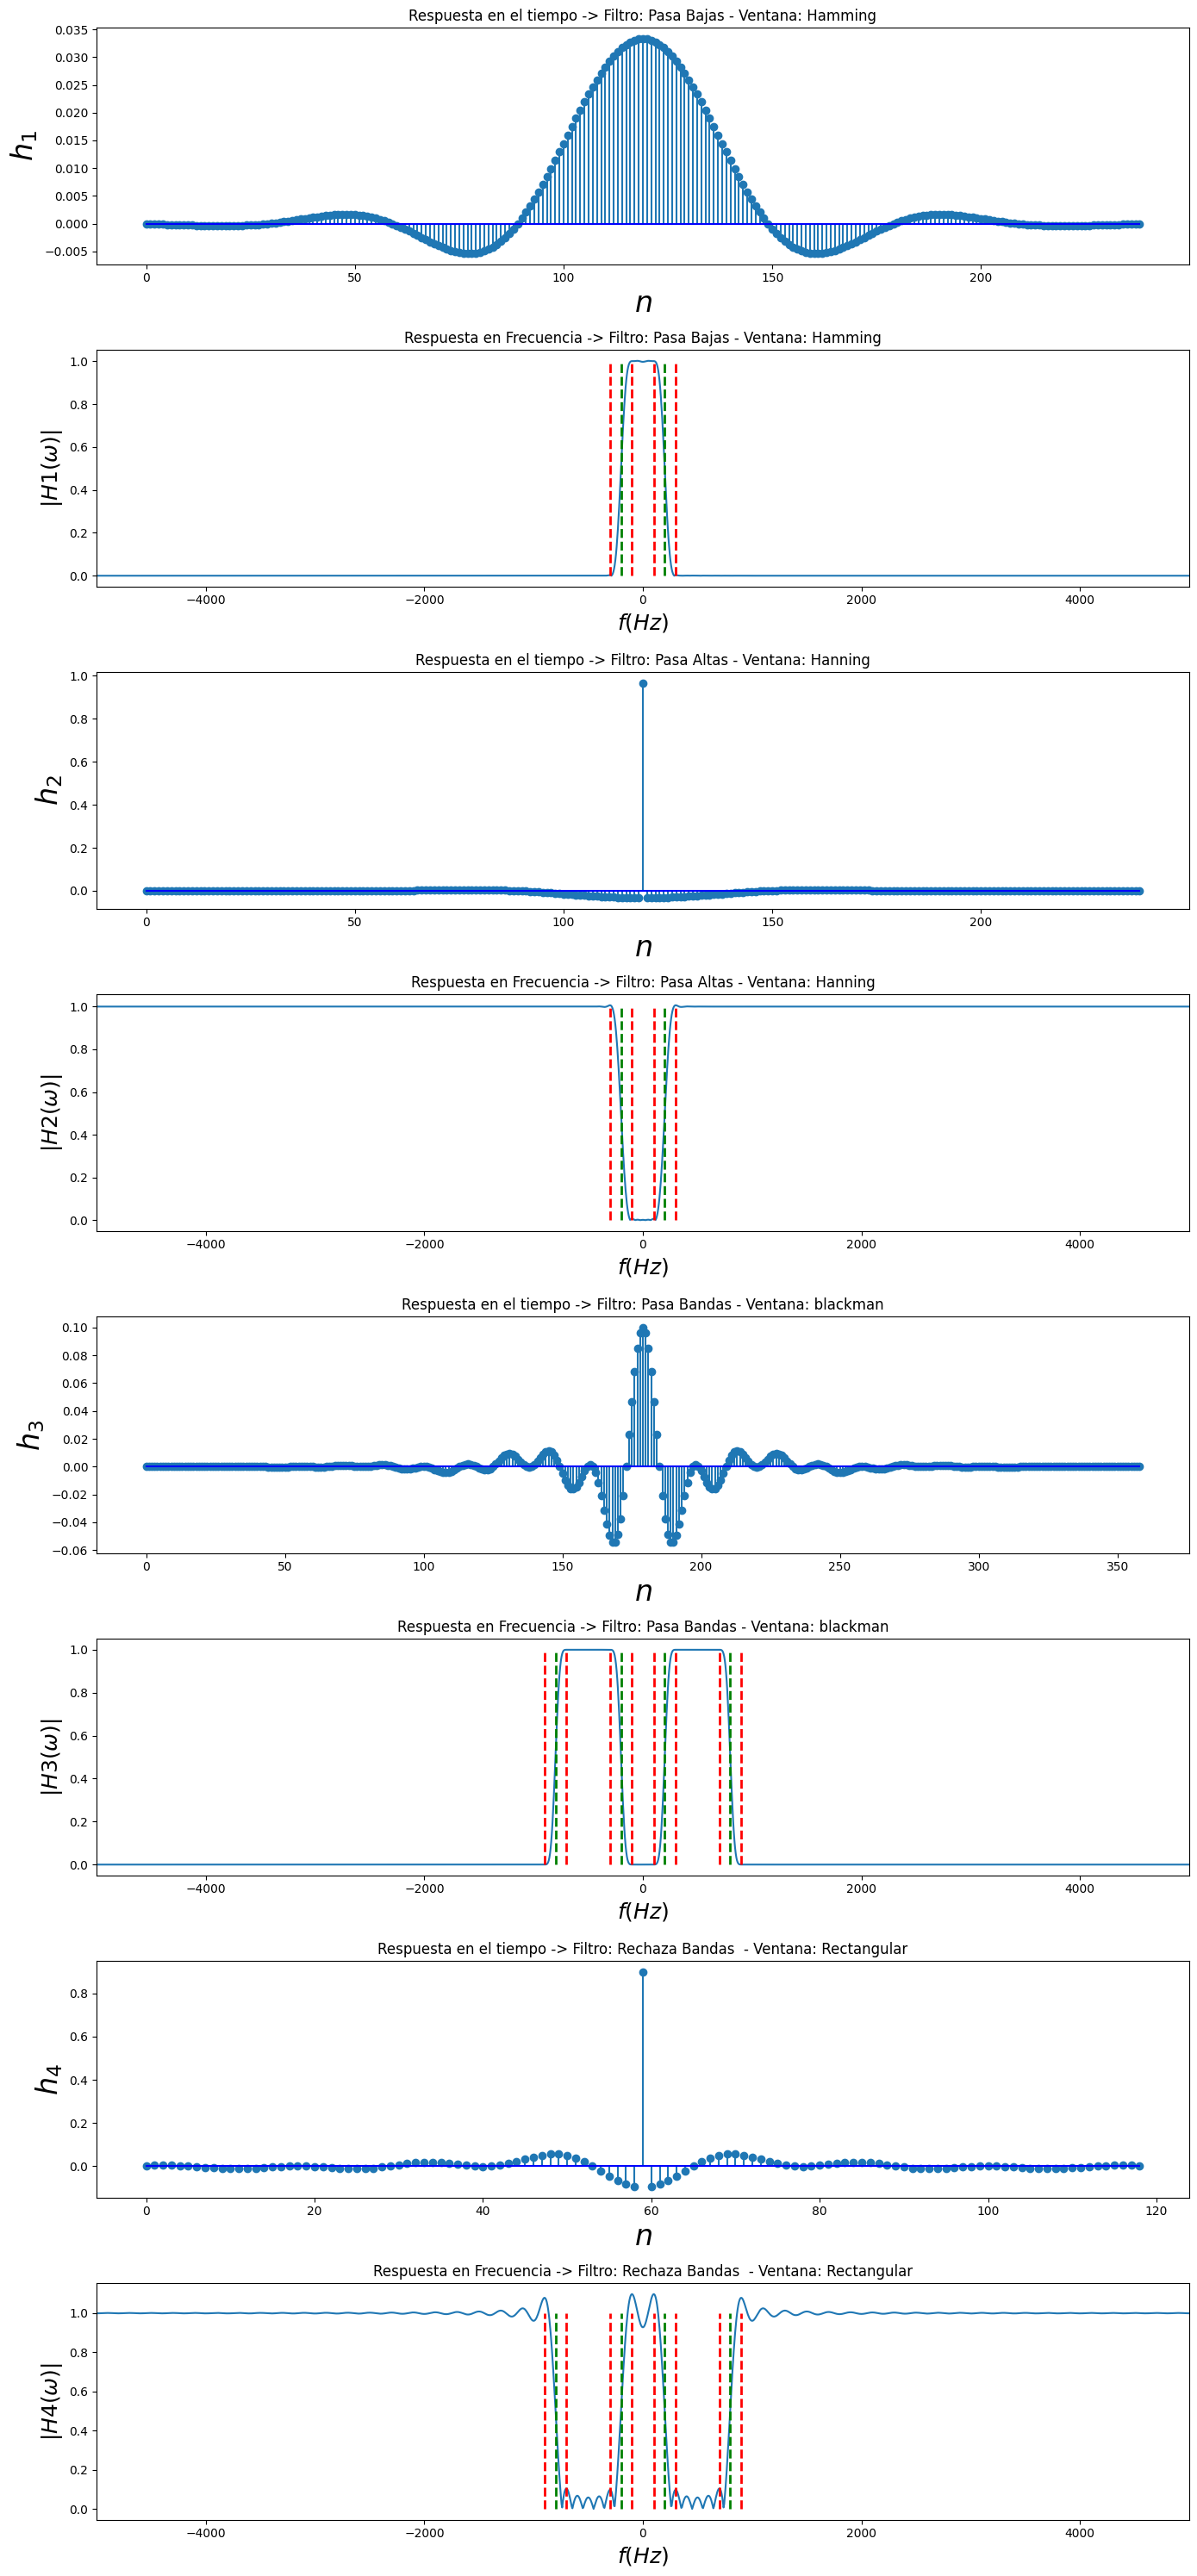

In [17]:
plt.figure(figsize=(14,30))
#PASA BAJAS TIEMPO
plt.subplot(811)
plt.stem(vector_n_1 + ((M1-1)/2),h_pasabajas ,basefmt='b-')
plt.title("Respuesta en el tiempo -> Filtro: Pasa Bajas - Ventana: Hamming")
plt.xlabel("$n$",fontsize=24)
plt.ylabel("$h_1$",fontsize=24)


#PASA BAJAS FRECUENCIA
plt.subplot(812)
plt.plot((w_pasabajas-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh_pasabajas))) # Grafico en frecuencia
plt.vlines([-fc,fc],0,1,color='g',lw=2.,linestyle='--')
plt.vlines([-fc-BW/2,-fc+BW/2,fc-BW/2 ,fc+BW/2],0,1,color='r',lw=2.,linestyle='--')
plt.axis(xmax=fs/2,xmin=-fs/2)
plt.title("Respuesta en Frecuencia -> Filtro: Pasa Bajas - Ventana: Hamming")
plt.xlabel(r"$f (Hz)$",fontsize=18)
plt.ylabel(r"$|H1(\omega)| $",fontsize=18)
plt.xlim(-5000, 5000)


#PASA ALTAS TIEMPO
plt.subplot(813)
plt.stem(vector_n_2 + ((M2-1)/2),h_pasaaltas  ,basefmt='b-')
plt.title("Respuesta en el tiempo -> Filtro: Pasa Altas - Ventana: Hanning")
plt.xlabel("$n$",fontsize=24)
plt.ylabel("$h_2$",fontsize=24)


#PASA ALTAS FRECUENCIA
plt.subplot(814)
plt.plot((w_pasaaltas-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh_pasaaltas))) # Grafico en frecuencia
plt.vlines([-fc,fc],0,1,color='g',lw=2.,linestyle='--')
plt.vlines([-fc-BW/2,-fc+BW/2,fc-BW/2 ,fc+BW/2],0,1,color='r',lw=2.,linestyle='--')
plt.axis(xmax=fs/2,xmin=-fs/2)
plt.title("Respuesta en Frecuencia -> Filtro: Pasa Altas - Ventana: Hanning")
plt.xlabel(r"$f (Hz)$",fontsize=18)
plt.ylabel(r"$|H2(\omega)| $",fontsize=18)
plt.xlim(-5000, 5000)


#PASA BANDAS TIEMPO
plt.subplot(815)
plt.stem(vector_n_3 + ((M3-1)/2),h_pasabandas  ,basefmt='b-')
plt.title("Respuesta en el tiempo -> Filtro: Pasa Bandas - Ventana: blackman")
plt.xlabel("$n$",fontsize=24)
plt.ylabel("$h_3$",fontsize=24)


#PASA BANDAS FRECUENCIA
plt.subplot(816)
plt.plot((w_pasabandas-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh_pasabandas))) # Grafico en frecuencia
plt.vlines([-fc,fc],0,1,color='g',lw=2.,linestyle='--')
plt.vlines([-fc2,fc2],0,1,color='g',lw=2.,linestyle='--')
plt.vlines([-fc-BW/2,-fc+BW/2,fc-BW/2 ,fc+BW/2],0,1,color='r',lw=2.,linestyle='--')
plt.vlines([-fc2-BW/2,-fc2+BW/2,fc2-BW/2 ,fc2+BW/2],0,1,color='r',lw=2.,linestyle='--')
plt.axis(xmax=fs/2,xmin=-fs/2)
plt.title("Respuesta en Frecuencia -> Filtro: Pasa Bandas - Ventana: blackman")
plt.xlabel(r"$f (Hz)$",fontsize=18)
plt.ylabel(r"$|H3(\omega)| $",fontsize=18)
plt.xlim(-5000, 5000)


#RECHAZA BANDAS TIEMPO
plt.subplot(817)
plt.stem(vector_n_4 + ((M4-1)/2),h_rechazabandas  ,basefmt='b-')
plt.title("Respuesta en el tiempo -> Filtro: Rechaza Bandas  - Ventana: Rectangular")
plt.xlabel("$n$",fontsize=24)
plt.ylabel("$h_4$",fontsize=24)


#RECHAZA BANDAS FRECUENCIA
plt.subplot(818)
plt.plot((w_rechazabandas-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh_rechazabandas))) # Grafico en frecuencia
plt.vlines([-fc,fc],0,1,color='g',lw=2.,linestyle='--')
plt.vlines([-fc2,fc2],0,1,color='g',lw=2.,linestyle='--')
plt.vlines([-fc-BW/2,-fc+BW/2,fc-BW/2 ,fc+BW/2],0,1,color='r',lw=2.,linestyle='--')
plt.vlines([-fc2-BW/2,-fc2+BW/2,fc2-BW/2 ,fc2+BW/2],0,1,color='r',lw=2.,linestyle='--')
plt.axis(xmax=fs/2,xmin=-fs/2)
plt.title("Respuesta en Frecuencia -> Filtro: Rechaza Bandas  - Ventana: Rectangular")
plt.xlabel(r"$f (Hz)$",fontsize=18)
plt.ylabel(r"$|H4(\omega)| $",fontsize=18)
plt.xlim(-5000, 5000)

plt.tight_layout()
plt.show()